## Reshape

In [ ]:
import os
from PIL import Image
file_dir = 'C:\\Users\\User\\GAN\\SA'
files = os.listdir(file_dir)
count = 0
for file in files: 
    img = Image.open(file_dir +'\\' +file)
    (w, h) = img.size
    print('w=%d, h=%d', w, h)
    #img.show()
    count += 1
    new_img = img.resize((34*1.5,46*1.5))
    #new_img.show()
    new_img.save('C:\\Users\\User\\GAN\\SA'+'\\' +str(count)+'.png')

## Lable Image

In [ ]:
import os
import cv2
import numpy as np
file_dir = 'C:\\Users\\User\\GAN\\SA'
files = os.listdir(file_dir)
count = 0
images = []
for file in files: 
    img = cv2.imread(file_dir +'\\' +file)
    #(w, h) = img.size
    #print('w=%d, h=%d', w, h)
    #img.show()
    count += 1
    new_img = cv2.resize(img,(34, 46))
    #new_img.show()
    #imgcv = cv2.cvtColor(np.asarray(new_img),cv2.COLOR_RGB2BGR) 
    
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    images.append(new_img)
images = np.array(images)

In [ ]:
def decode(num):
    
    if num // 13 == 0:
        numID = 'S'+str(trans(num))
    elif num // 13 == 1:
        numID = 'H'+str(trans(num))
    elif num // 13 == 2:
        numID = 'D'+str(trans(num))
    elif num // 13 == 3:
        numID = 'C'+str(trans(num))
    return numID

def trans(num):
    num += 1
    if num % 13 == 1:
        return 'A'
    elif num % 13 == 11:
        return 'J'
    elif num % 13 == 12:
        return 'Q'
    elif num % 13 == 0:
        return 'K'
    else:
        return str(num % 13)
        

In [ ]:
import pickle
classifier = pickle.load(open('C:\\Users\\User\\Poker\\classifier.p','rb'))

In [ ]:
lableImg = []
for i in np.argmax(classifier.predict(images),axis=1):
    lableImg.append(i)

In [ ]:
pickle.dump(lableImg, open('lableImg.p','wb'))

## One class GAN

In [ ]:
import tensorflow as tf
import os
import pickle
from IPython.display import clear_output
import keras.backend as K
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# config = tf.ConfigProto(allow_soft_placement = True)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
# config.gpu_options.allow_growth = True
 
# sess0 = tf.InteractiveSession(config = config)
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

def mutual_info_loss(c, c_given_x):
    """The mutual information metric we aim to minimize"""
    eps = 1e-8
    conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
    entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

    return conditional_entropy + entropy
'''
生成器（generator）
首先，建立一個“生成器（generator）”模型，它將一個向量（從潛在空間 - 在訓練期間隨機取樣）轉換為候選影象。
GAN通常出現的許多問題之一是generator卡在生成的影象上，看起來像噪聲。一種可能的解決方案是在鑑別器（discriminator）
和生成器（generator）上使用dropout。
'''
import keras
from keras import layers
import numpy as np

latent_dim = 46
height = 92
width = 68
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 首先，將輸入轉換為16x16 128通道的feature map
# x = layers.Dense(32 * 46 * 17)(generator_input)
# x = layers.LeakyReLU()(x)
# # x = layers.Dense(128 * 46 * 17)(x)
# # x = layers.LeakyReLU()(x)
x = layers.Dense(128 * 46 * 34)(generator_input)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.3)(x)
x = layers.Reshape((46, 34, 128))(x)

# 然後，添加捲積層
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# 上取樣至 32 x 32
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.LeakyReLU()(x)
# 新增更多的卷積層
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# 生成一個 32x32 1-channel 的feature map
x = layers.Conv2D(channels, 16, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()


# In[8]:


'''
discriminator(鑑別器)
建立鑑別器模型，它將候選影象（真實的或合成的）作為輸入，並將其分為兩類：“生成的影象”或“來自訓練集的真實影象”。
'''
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(32)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
# 重要的技巧（新增一個dropout層）
x = layers.Dropout(0,4)(x)

# 分類層
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# In[11]:

# 為了訓練穩定，在優化器中使用學習率衰減和梯度限幅（按值）。
discriminator_optimizer = keras.optimizers.adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


# In[16]:

generator = pickle.load(open('generator3.p','rb'))
discriminator = pickle.load(open('discriminator3.p','rb'))
'''
The adversarial network:對抗網路
最後，設定GAN，它連結生成器（generator）和鑑別器（discrimitor）。 這是一種模型，經過訓練，
將使生成器（generator）朝著提高其愚弄鑑別器（discrimitor）能力的方向移動。 該模型將潛在的空間點轉換為分類決策，
“假的”或“真實的”，並且意味著使用始終是“這些是真實影象”的標籤來訓練。 所以訓練`gan`將以一種方式更新
“發生器”的權重，使得“鑑別器”在檢視假影象時更可能預測“真實”。 非常重要的是，將鑑別器設定為在訓練
期間被凍結（不可訓練）：訓練“gan”時其權重不會更新。 如果在此過程中可以更新鑑別器權重，那麼將訓練鑑別
器始終預測“真實”。
'''
# 將鑑別器（discrimitor）權重設定為不可訓練（僅適用於`gan`模型）
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
#losses = [ mutual_info_loss]
gan_optimizer = keras.optimizers.adam(learning_rate=4e-6, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


# In[19]:


# gan = pickle.load(open('gan.p','rb'))
'''
  開始訓練了。
  每個epoch：
   *在潛在空間中繪製隨機點（隨機噪聲）。
   *使用此隨機噪聲生成帶有“generator”的影象。
   *將生成的影象與實際影象混合。
   *使用這些混合影象訓練“鑑別器”，使用相應的目標，“真實”（對於真實影象）或“假”（對於生成的影象）。
   *在潛在空間中繪製新的隨機點。
   *使用這些隨機向量訓練“gan”，目標都是“這些是真實的影象”。 這將更新發生器的權重（僅因為鑑別器在“gan”內被凍結）
   以使它們朝向獲得鑑別器以預測所生成影象的“這些是真實影象”，即這訓練發生器欺騙鑑別器。
'''
import os
from keras.preprocessing import image
import cv2
import numpy as np
'''
# 匯入CIFAR10資料集
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 從CIFAR10資料集中選擇frog類（class 6）
x_train = x_train[y_train.flatten() == 6]

# 標準化資料
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.
'''

dirPath = 'C:/Users/User/GAN/SA'
SA = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
x_train = []
for img in SA:
    imgcv = cv2.imread(dirPath+'/'+img)
    imgcv = cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)
    x_train.append(imgcv)
x_train = np.array(x_train)
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.


iterations = 450000000000
batch_size = 20
save_dir = '.\\gan_image3'

start = 0 

with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
    generator = generator
    discriminator = discriminator
    gan = gan
    
# 開始訓練迭代
for step in range(iterations):
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 將隨機抽樣點解碼為假影象
    generated_images = generator.predict(random_latent_vectors)
    
    # 將假影象與真實影象進行比較
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 組裝區別真假影象的標籤
    labels = np.concatenate([np.ones((batch_size, 1)),
                            np.zeros((batch_size, 1))])
    # 重要的技巧，在標籤上新增隨機噪聲
    labels += 0.05 * np.random.random(labels.shape)
    
    # 訓練鑑別器（discrimitor）
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # 在潛在空間中取樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 彙集標有“所有真實影象”的標籤
    misleading_targets = np.zeros((batch_size, 1))
    
    # 訓練生成器（generator）（通過gan模型，鑑別器（discrimitor）權值被凍結）
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        # 儲存網路權值
        gan.save_weights('gan.h5')
        if step % 100 == 0:
            print(discriminator.predict(combined_images))
        # 輸出metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # 儲存生成的影象
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, str(step) + '.png'))
        
        pickle.dump(discriminator,open('discriminator3.p','wb'))
        pickle.dump(generator,open('generator3.p','wb'))
        pickle.dump(gan,open('gan3.p','wb'))
        
        # 儲存真實影象，以便進行比較
#         img = image.array_to_img(real_images[0] * 255., scale=False)
#         img.save(os.path.join(save_dir, 'real_SA' + str(step) + '.png'))
    if step % 1000 == 0:
        clear_output()

# In[ ]:


# 繪圖
import matplotlib.pyplot as plt

# 在潛在空間中抽樣隨機點
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 將隨機抽樣點解碼為假影象
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

## Classify GAN

In [3]:
import tensorflow as tf
import os
import pickle
from IPython.display import clear_output
import keras.backend as K
from tensorflow.keras import backend
from tensorflow.python.keras import backend as k
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
# from keras.utils.training_utils import multi_gpu_model  
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# config = tf.ConfigProto(allow_soft_placement = True)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
# config.gpu_options.allow_growth = True
 
# sess0 = tf.InteractiveSession(config = config)
strategy = tf.distribute.MirroredStrategy()
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

def mutual_info_loss(c, c_given_x):
    """The mutual information metric we aim to minimize"""
    eps = 1e-8
    conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
    entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

    return conditional_entropy + entropy
'''
生成器（generator）
首先，建立一個“生成器（generator）”模型，它將一個向量（從潛在空間 - 在訓練期間隨機取樣）轉換為候選影象。
GAN通常出現的許多問題之一是generator卡在生成的影象上，看起來像噪聲。一種可能的解決方案是在鑑別器（discriminator）
和生成器（generator）上使用dropout。
'''
import keras
from keras import layers
import numpy as np

num_classes = 52
latent_dim = 46
height = 92
width = 68
channels = 3

# 兩個input，分別是亂數、類別
latent = keras.Input(shape=(latent_dim,))
image_class = Input(shape=(1,), dtype='int32')
cls = Embedding(num_classes, latent_dim,
                embeddings_initializer='glorot_normal')(image_class)

generator_input = layers.add([latent, cls])
# 首先，將輸入轉換為16x16 128通道的feature map
# x = layers.Dense(32 * 46 * 17)(generator_input)
# x = layers.LeakyReLU()(x)
# # x = layers.Dense(128 * 46 * 17)(x)
# # x = layers.LeakyReLU()(x)
x = layers.Dense(128 * 46 * 34)(generator_input)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.3)(x)
x = layers.Reshape((46, 34, 128))(x)

# 然後，添加捲積層
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# 上取樣至 32 x 32
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.LeakyReLU()(x)
# 新增更多的卷積層
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# 生成一個 32x32 1-channel 的feature map
x = layers.Conv2D(channels, 16, activation='tanh', padding='same')(x)
generator = keras.models.Model([latent, image_class], x)
generator.summary()


# In[8]:


'''
discriminator(鑑別器)
建立鑑別器模型，它將候選影象（真實的或合成的）作為輸入，並將其分為兩類：“生成的影象”或“來自訓練集的真實影象”。
'''
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(32)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
# 重要的技巧（新增一個dropout層）
x = layers.Dropout(0,4)(x)

# 分類層
isFake = layers.Dense(1, activation='sigmoid')(x)
classDetac = layers.Dense(num_classes, activation ='softmax')(x)

discriminator = keras.models.Model(discriminator_input, [isFake,classDetac])
discriminator.summary()

# In[11]:
generator = pickle.load(open('generatorClass.p','rb'))
discriminator = pickle.load(open('discriminatorClass.p','rb'))
# 為了訓練穩定，在優化器中使用學習率衰減和梯度限幅（按值）。
discriminator_optimizer = keras.optimizers.adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
discriminator.compile(optimizer=discriminator_optimizer, loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])


# In[16]:


'''
The adversarial network:對抗網路
最後，設定GAN，它連結生成器（generator）和鑑別器（discrimitor）。 這是一種模型，經過訓練，
將使生成器（generator）朝著提高其愚弄鑑別器（discrimitor）能力的方向移動。 該模型將潛在的空間點轉換為分類決策，
“假的”或“真實的”，並且意味著使用始終是“這些是真實影象”的標籤來訓練。 所以訓練`gan`將以一種方式更新
“發生器”的權重，使得“鑑別器”在檢視假影象時更可能預測“真實”。 非常重要的是，將鑑別器設定為在訓練
期間被凍結（不可訓練）：訓練“gan”時其權重不會更新。 如果在此過程中可以更新鑑別器權重，那麼將訓練鑑別
器始終預測“真實”。
'''
# 將鑑別器（discrimitor）權重設定為不可訓練（僅適用於`gan`模型）

discriminator.trainable = False

fakeImg = generator([latent, image_class])
fake, aux = discriminator(fakeImg)

gan = keras.models.Model([latent, image_class], [fake, aux])
#losses = [ mutual_info_loss]
gan_optimizer = keras.optimizers.adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
gan.compile(optimizer=gan_optimizer, loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])
gan.summary()

# In[19]:


# gan = pickle.load(open('gan.p','rb'))
'''
  開始訓練了。
  每個epoch：
   *在潛在空間中繪製隨機點（隨機噪聲）。
   *使用此隨機噪聲生成帶有“generator”的影象。
   *將生成的影象與實際影象混合。
   *使用這些混合影象訓練“鑑別器”，使用相應的目標，“真實”（對於真實影象）或“假”（對於生成的影象）。
   *在潛在空間中繪製新的隨機點。
   *使用這些隨機向量訓練“gan”，目標都是“這些是真實的影象”。 這將更新發生器的權重（僅因為鑑別器在“gan”內被凍結）
   以使它們朝向獲得鑑別器以預測所生成影象的“這些是真實影象”，即這訓練發生器欺騙鑑別器。
 '''
import os
from keras.preprocessing import image
import cv2
import numpy as np
'''
# 匯入CIFAR10資料集
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 從CIFAR10資料集中選擇frog類（class 6）
x_train = x_train[y_train.flatten() == 6]

# 標準化資料
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.
'''

dirPath = 'C:/Users/User/GAN/SA'
SA = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
x_train = []
for img in SA:
    imgcv = cv2.imread(dirPath+'/'+img)
    imgcv = cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)
    x_train.append(imgcv)
x_train = np.array(x_train)
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

lableImg = pickle.load(open('lableImg.p','rb'))

iterations = 450000000000
batch_size = 40
save_dir = '.\\gan_image3'

start = 0 

with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
    generator = generator
    discriminator = discriminator
    gan = gan

# 開始訓練迭代
for step in range(9301,iterations):
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # 隨機選擇化哪個類別
    random_labels = np.random.randint(0, num_classes, batch_size)
    # 將隨機抽樣點解碼為假影象
    generated_images = generator.predict([random_latent_vectors,random_labels.reshape((-1, 1))])
    
    # 將假影象與真實影象進行比較
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 取真實類別的標籤
    
    
    # 組裝區別真假影象的標籤
    labels = np.concatenate([np.ones((batch_size, 1)),
                            np.zeros((batch_size, 1))])
    # 組裝區別真假類別的標籤
    claLabels = lableImg[start: stop]
    combined_clsLable = np.concatenate([random_labels, claLabels])
    #combined_clsLable = np.concatenate([np.negative(np.ones((batch_size))), claLabels])
    
    # 重要的技巧，在標籤上新增隨機噪聲
    labels += 0.1 * np.random.random(labels.shape)
    labels -= 0.1 * np.random.random(labels.shape)
    # Assign sample weight
    disc_sample_weight = [np.ones(2 * (batch_size)),
                                  np.concatenate((np.zeros(batch_size) ,
                                                  np.ones(batch_size)*3))]
    # 訓練鑑別器（discrimitor）
    d_loss = discriminator.train_on_batch(combined_images, [labels,combined_clsLable], sample_weight=disc_sample_weight)
    

    
    # 彙集標有“所有真實影象”的標籤
    misleading_targets = np.zeros((batch_size, 1))
    
    # 再做一個新的亂數和標籤
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # 隨機選擇化哪個類別
    random_labels = np.random.randint(0, num_classes, batch_size)
    
    # 訓練生成器（generator）（通過gan模型，鑑別器（discrimitor）權值被凍結）
    a_loss = gan.train_on_batch([random_latent_vectors,random_labels.reshape((-1, 1))], [misleading_targets,random_labels])
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        # 儲存網路權值
        gan.save_weights('gan.h5')
        if step % 100 == 0:
            print(discriminator.predict(combined_images))
        # 輸出metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # 儲存生成的影象
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, str(step) + '.png'))
        
        pickle.dump(discriminator,open('discriminatorClass.p','wb'))
        pickle.dump(generator,open('generatorClass.p','wb'))
        pickle.dump(gan,open('ganClass.p','wb'))
        
        # 儲存真實影象，以便進行比較
#         img = image.array_to_img(real_images[0] * 255., scale=False)
#         img.save(os.path.join(save_dir, 'real_SA' + str(step) + '.png'))
    if step % 1000 == 0:
        clear_output()

# In[ ]:


# 繪圖
import matplotlib.pyplot as plt

# 在潛在空間中抽樣隨機點
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 將隨機抽樣點解碼為假影象
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

[array([[1.47470355e-01],
       [1.56334907e-01],
       [9.99214888e-01],
       [9.36245382e-01],
       [1.15088016e-01],
       [2.74349511e-01],
       [7.33940065e-01],
       [5.73345423e-01],
       [1.74733341e-01],
       [5.70770204e-02],
       [2.10945159e-01],
       [5.11266828e-01],
       [5.17272353e-02],
       [9.31376815e-01],
       [1.47854388e-01],
       [9.32964087e-02],
       [7.61698484e-02],
       [1.45776451e-01],
       [9.56708550e-01],
       [9.34413195e-01],
       [7.25415230e-01],
       [9.88277495e-01],
       [4.75151062e-01],
       [9.43077683e-01],
       [3.60857248e-02],
       [7.07108378e-01],
       [9.31634665e-01],
       [7.08956599e-01],
       [8.96863043e-02],
       [1.80860370e-01],
       [4.08274680e-01],
       [9.98879313e-01],
       [8.45223427e-01],
       [7.24961817e-01],
       [2.86647171e-01],
       [7.77900934e-01],
       [6.71663404e-01],
       [2.22513229e-01],
       [1.40100688e-01],
       [9.42057848e-01],

[array([[0.3642387 ],
       [0.7055403 ],
       [0.18680304],
       [0.02216926],
       [0.9534702 ],
       [0.09810886],
       [0.8350328 ],
       [0.6669894 ],
       [0.11461726],
       [0.08626065],
       [0.47773266],
       [0.03063232],
       [0.73594546],
       [0.53387254],
       [0.24205413],
       [0.17007235],
       [0.57187754],
       [0.04524055],
       [0.4132812 ],
       [0.5972223 ],
       [0.06287298],
       [0.7960311 ],
       [0.9553867 ],
       [0.9862602 ],
       [0.880314  ],
       [0.7294006 ],
       [0.06818044],
       [0.35568064],
       [0.32454288],
       [0.571925  ],
       [0.35870272],
       [0.62163985],
       [0.89021707],
       [0.58179617],
       [0.29373947],
       [0.9983796 ],
       [0.20909417],
       [0.08518589],
       [0.2707007 ],
       [0.8913122 ],
       [0.01352116],
       [0.00366783],
       [0.00667939],
       [0.03197187],
       [0.02301225],
       [0.00580072],
       [0.01189777],
       [0.00

KeyboardInterrupt: 

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5405014136208543917,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5492748718966077166
 physical_device_desc: "device: XLA_CPU device"]

In [2]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
print(tf.__version__)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
2.2.0-dev20200325


## Test generator

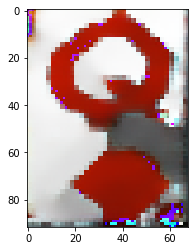

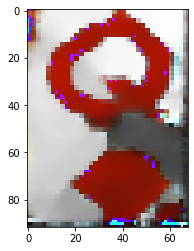

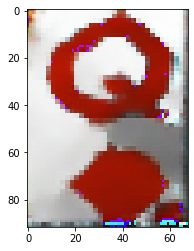

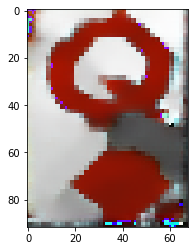

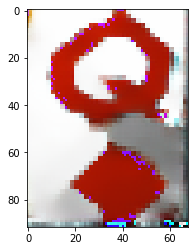

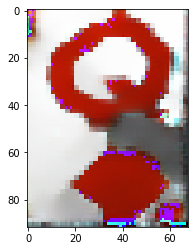

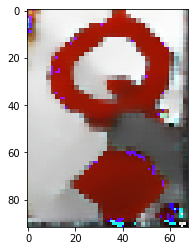

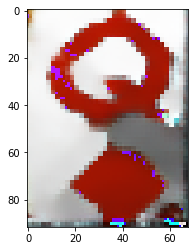

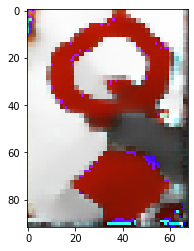

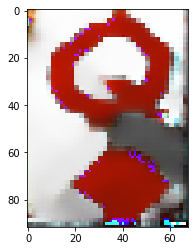

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from keras_preprocessing import image
import pickle

generator = pickle.load(open('generatorClass.p','rb'))
latent_dim = 46
height = 92
width = 68
channels = 3
picNum = 10
# 在潛在空間中抽樣隨機點
random_latent_vectors = np.random.normal(size=(picNum, latent_dim))
l = []
for i in range(picNum):
    l.append(50)
# 將隨機抽樣點解碼為假影象
generated_images = generator.predict([random_latent_vectors,np.array(l)])

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

## Reverse

In [ ]:
import keras
from keras import layers
import numpy as np
import pickle
generator = pickle.load(open('generator.p','rb'))

import tensorflow as tf
import os
from IPython.display import clear_output
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# config = tf.ConfigProto(allow_soft_placement = True)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 1)
# config.gpu_options.allow_growth = True
 
# sess0 = tf.InteractiveSession(config = config)

latent_dim = 46
height = 46
width = 35
channels = 3

decodedGenerator = layers.Input(shape=(height, width, channels))

x = layers.Flatten()(decodedGenerator)
x = layers.Dense(256 * 46 * 35)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(latent_dim)(x)

decodedGenerator = keras.models.Model(decodedGenerator, x)
decodedGenerator.summary()

decodedGenerator_optimizer = keras.optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
decodedGenerator.compile(optimizer=decodedGenerator_optimizer, loss='mean_squared_error')

generator.summary()
#====================================================================


In [ ]:
for i in range(100000):
    
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(2, latent_dim))

    # 將隨機抽樣點解碼為假影象
    generated_images = generator.predict(random_latent_vectors)

    decodeLoss = decodedGenerator.train_on_batch(generated_images,random_latent_vectors)
'''    
    if i% 100 == 0:
        print(decodeLoss)
        pickle.dump(open('decoder.p','rb'))
        
        decodeImages = generator.predict(decodedGenerator.predict(generated_images))
        
        for i in range(3):
            print('original: \n')
            img = image.array_to_img(generated_images[i] * 255., scale=False)
            plt.figure()
            plt.imshow(img)
            print('decode: \n')
            img = image.array_to_img(decodeImages[i] * 255., scale=False)
            plt.figure()
            plt.imshow(img)
            
            

        plt.show()
'''